nutrition prediction

# 📦 Step 1: Imports

In [10]:
import os
import json
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm


# 🔁 Step 2: Load All JSON Files

In [3]:
import os
import json

def load_all_products(path='products'):
    data = []
    for file in os.listdir(path):
        if file.endswith('.json'):
            file_path = os.path.join(path, file)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = json.load(f)
                    if isinstance(content, list):
                        data.extend(content)
                    elif isinstance(content, dict):
                        data.append(content)
            except Exception as e:
                print(f"⚠️ Error loading {file}: {e}")
    return data


# 📥 Load and display summary
raw_data = load_all_products("products")  # Update folder name if needed
print(f"\n📦 Total raw product entries loaded: {len(raw_data)}")

# 🧐 Preview one product if available
if raw_data:
    print("\n📄 Sample raw_data[0]:")
    print(json.dumps(raw_data[0], indent=2, ensure_ascii=False))
else:
    print("❌ No data loaded.")


📦 Total raw product entries loaded: 2570

📄 Sample raw_data[0]:
{
  "ean": "salade-pecheur-35g",
  "business_type": "food",
  "categories": [
    {
      "label": "Algues, Graines à germer"
    }
  ],
  "market": {
    "name": "Naturalia",
    "country": "FR",
    "address": "Paris"
  },
  "lang_desc": {
    "fr": {
      "title": "SALADE DU PÊCHEUR AUX 3 ALGUES 35G BIO",
      "desc": "Salade du pêcheur aux 3 algues 35G Bio.\nDécouvrez la salade du pêcheur aux trois algues déshydratées: Dulse, Nori, et Laitue de mer.\n100% Bio.",
      "images": [
        "https://media.naturalia.fr/media/catalog/product/cache/c97961dbe2ef8ae9072b778469b58f9a/3/5/3565840206090_1.jpg"
      ],
      "links": {
        "links_self": "https://www.naturalia.fr/produit/salade-pecheur-35g"
      }
    }
  },
  "evolutions": [
    {
      "parsing_date": "2025-06-15T22:25",
      "format": "35G",
      "availability": true,
      "nutrition": {
        "minerals": {
          "salt": 4400
        },
       

# 📦 Step 3: Flatten and Extract Relevant Fields

In [11]:
def extract_product_info(product):
    try:
        evolution = product.get("evolutions", [{}])[0]
        nutrition = evolution.get("nutrition", {})
        energies = nutrition.get("energies", {})
        minerals = nutrition.get("minerals", {})
        fats = nutrition.get("fats", {})
        proteins = nutrition.get("proteins", {})
        carbs = nutrition.get("carbohydrates", {})

        return {
            "ean": product.get("ean"),
            "title": product.get("lang_desc", {}).get("fr", {}).get("title"),
            "desc": product.get("lang_desc", {}).get("fr", {}).get("desc"),
            "brand": product.get("brand", {}).get("name"),
            "category": product.get("categories", [{}])[0].get("label"),
            "origin": product.get("origin", {}).get("explicit"),
            "market": product.get("market", {}).get("name"),
            "country": product.get("market", {}).get("country"),
            "ingredients": evolution.get("ingredients"),
            "fats": fats.get("fats"),
            "saturates": fats.get("saturates"),
            "salt": minerals.get("salt"),
            "proteins": proteins.get("proteins"),
            "carbohydrates": carbs.get("carbohydrates"),
            "kj": energies.get("kj"),
            "nutriscore": evolution.get("nutriscore"),
            "price": evolution.get("price_per_packaging"),
            "discounted": evolution.get("on_discount"),
            "requires_loyalty_card": evolution.get("requires_loyalty_card"),
            "reviews_avg": product.get("customer_reviews", {}).get("average_rating"),
            "reviews_total": product.get("customer_reviews", {}).get("total_reviews")
        }
    except Exception as e:
        print(f"❌ Error in product {product.get('ean')}: {e}")
        return None


products_data = [extract_product_info(prod) for prod in raw_data]
df = pd.DataFrame([p for p in products_data if p is not None])

print(f"✅ Extracted {len(df)} valid product entries.\n")
print(df.head())

✅ Extracted 2570 valid product entries.

                        ean  \
0        salade-pecheur-35g   
1    germoir-verre-germline   
2  alfa-cress-ch-rouge-150g   
3   alfa-radis-fenouil-150g   
4     alfalfa-a-germer-150g   

                                               title  \
0             SALADE DU PÊCHEUR AUX 3 ALGUES 35G BIO   
1             GERMOIR EN VERRE POUR GRAINES À GERMER   
2  ALFA CRESSON CHOU ROUGE GRAINES À GERMER 150G BIO   
3       ALFA RADIS FENOUIL GRAINES À GERMER 150G BIO   
4                  ALFALFA GRAINES À GERMER 150G BIO   

                                                desc brand  \
0  Salade du pêcheur aux 3 algues 35G Bio.\nDécou...  None   
1  Germoir en verre pour graines à germer.\nVous ...  None   
2  Alfa Cresson Chou Rouge graines à germer 150G ...  None   
3  Alfa Radis Fenouil graines à germer 150G Bio\n...  None   
4  Alfalfa graines à germer 150G Bio\nDe la famil...  None   

                   category origin     market country  \
0  Al

# 🧹 Step 4: NLP Cleaning

In [12]:
nlp = spacy.load("fr_core_news_sm")
nltk.download('stopwords')
french_stopwords = set(stopwords.words('french'))

nlp = spacy.load("fr_core_news_sm")
nltk.download('stopwords')
french_stopwords = set(stopwords.words('french'))

# ✅ Nettoyage NLP
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zàâçéèêëîïôûùüÿñæœ\s]", "", text)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.lemma_ not in french_stopwords and len(token.lemma_) > 2]
    return " ".join(tokens)

# 📄 Appliquer le nettoyage
tqdm.pandas()
df['clean_desc'] = df['desc'].progress_apply(clean_text)
df['clean_ingredients'] = df['ingredients'].progress_apply(clean_text)

# 🧪 Fusion du texte nettoyé
df['nlp_text'] = (df['clean_desc'].fillna("") + " " + df['clean_ingredients'].fillna("")).str.strip()

# 🧠 Vectorisation TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['nlp_text'])

# 🔁 Calcul des similarités cosinus
similarity_matrix = cosine_similarity(X)

# 🚫 Marquer doublons (produits similaires > 0.9)
def find_duplicate_indices(sim_matrix, threshold=0.9):
    to_remove = set()
    for i in range(len(sim_matrix)):
        for j in range(i + 1, len(sim_matrix)):
            if sim_matrix[i, j] > threshold:
                to_remove.add(j)
    return list(to_remove)

duplicate_indices = find_duplicate_indices(similarity_matrix, threshold=0.9)

# 🧹 Supprimer les doublons
print(f"🚫 Doublons détectés : {len(duplicate_indices)}")
df_cleaned = df.drop(df.index[duplicate_indices]).reset_index(drop=True)
print(f"✅ Données nettoyées : {df_cleaned.shape[0]} produits restants")

# 📊 Optionnel : voir exemples
print(df_cleaned[['title', 'nlp_text']].sample(5))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 2570/2570 [03:31<00:00, 12.13it/s]


🚫 Doublons détectés : 565
✅ Données nettoyées : 2005 produits restants
                                                 title  \
57    BOUDOIRS À L'HUILE ESSENTIELLE D'ORANGE DOUCE...   
1486                   CREVETTES DÉCORTIQUÉES 100G BIO   
449                     GELÉE DE CASSIS EXTRA 260G BIO   
285                       POIS CHICHES FRANCE 750G BIO   
1501      SAUMON FUMÉ D'ATLANTIQUE EN TRANCHE 400G BIO   

                                               nlp_text  
57    boudoir lhuil essentiel dorange doux gramme bi...  
1486  crevette décortiquer bio découvrir crevette cu...  
449   gelée cassis extrer gramme bio découvrir gelée...  
285   pois chiche france gramme bio pois chiche issu...  
1501  saumon fumé datlantiqu tranche gramme bio saum...  


In [13]:
print(df.iloc[0])

ean                                                     salade-pecheur-35g
title                               SALADE DU PÊCHEUR AUX 3 ALGUES 35G BIO
desc                     Salade du pêcheur aux 3 algues 35G Bio.\nDécou...
brand                                                                 None
category                                          Algues, Graines à germer
origin                                                                None
market                                                           Naturalia
country                                                                 FR
ingredients              Dulse*, laitue de mer*, nori*.\n*Issu de l'Agr...
fats                                                                   1.4
saturates                                                              NaN
salt                                                                4400.0
proteins                                                              18.0
carbohydrates            

Full Pipeline with Multiple Models and Correlation Visualization

In [ ]:
# ⚠️ Ensure df['text'] is preprocessed clean text
vectorizer = TfidfVectorizer(max_features=1000)
df['text'] = df['clean_desc'].fillna('') + ' ' + df['clean_ingredients'].fillna('')
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['text'])

# Drop rows with NaNs in nutrition columns
target_cols = ['fats', 'saturates', 'salt', 'proteins', 'carbohydrates']
df_nutrition = df.dropna(subset=target_cols)

# Align features with cleaned labels
X = vectorizer.transform(df_nutrition['text'])
y = df_nutrition[target_cols]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🧠 Define Models
models = {
    'Ridge': MultiOutputRegressor(Ridge()),
    'LinearRegression': MultiOutputRegressor(LinearRegression()),
    'RandomForest': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    'XGBoost': MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
}

# 📊 Evaluate and Plot
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    r2 = r2_score(y_test, y_pred, multioutput='raw_values')

    results[name] = {
        'mse': mse,
        'r2': r2,
        'preds': y_pred
    }
    
    print(f"\n📌 {name} Performance:")
    for i, col in enumerate(target_cols):
        print(f"→ {col}: MSE={mse[i]:.2f}, R²={r2[i]:.2f}")

# 📈 Plot True vs Predicted
plt.figure(figsize=(15, 8))
for i, col in enumerate(target_cols):
    plt.subplot(2, 3, i+1)
    plt.scatter(y_test[col], results['RandomForest']['preds'][:, i], alpha=0.6)
    plt.title(f"{col} (True vs Predicted)")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.grid(True)
plt.tight_layout()
plt.show()

# 📉 Correlation Matrix (between nutrition facts)
corr_matrix = y.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("📊 Correlation Matrix of Nutrition Labels")
plt.show()


📌 Ridge Performance:
→ fats: MSE=16.91, R²=0.67
→ saturates: MSE=4.14, R²=0.76
→ salt: MSE=0.07, R²=0.59
→ proteins: MSE=5.88, R²=0.77
→ carbohydrates: MSE=52.88, R²=0.78

📌 LinearRegression Performance:
→ fats: MSE=98.45, R²=-0.94
→ saturates: MSE=35.50, R²=-1.03
→ salt: MSE=0.46, R²=-1.88
→ proteins: MSE=22.26, R²=0.13
→ carbohydrates: MSE=226.10, R²=0.06


In [7]:
mse_summary = pd.DataFrame()
r2_summary = pd.DataFrame()

for name, result in results.items():
    mse_summary[name] = result['mse']
    r2_summary[name] = result['r2']

mse_summary.index = target_cols
r2_summary.index = target_cols

print("📉 Mean Squared Error (MSE) Comparison:")
display(mse_summary)

print("\n📈 R² Score Comparison:")
display(r2_summary)


📉 Mean Squared Error (MSE) Comparison:


,Ridge,LinearRegression,RandomForest,XGBoost
fats,16.909286,98.451255,11.703468,10.791868
saturates,4.137534,35.496914,3.203852,2.720892
salt,0.065419,0.463240,0.057944,0.059502
proteins,5.881626,22.259964,3.069406,3.477505
carbohydrates,52.880310,226.099792,41.503173,35.670746



📈 R² Score Comparison:


,Ridge,LinearRegression,RandomForest,XGBoost
fats,0.667117,-0.938149,0.769601,0.787547
saturates,0.763722,-1.027090,0.817041,0.844621
salt,0.593527,-1.878301,0.639972,0.630287
proteins,0.769636,0.128149,0.879781,0.863797
carbohydrates,0.779245,0.056120,0.826740,0.851088


C:\Users\amine\AppData\Local\Temp\ipykernel_18956\511337001.py:19: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\amine\AppData\Local\Temp\ipykernel_18956\511337001.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\amine\Desktop\Selinium-Scraping-NLP-ML-Mongo\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\amine\Desktop\Selinium-Scraping-NLP-ML-Mongo\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


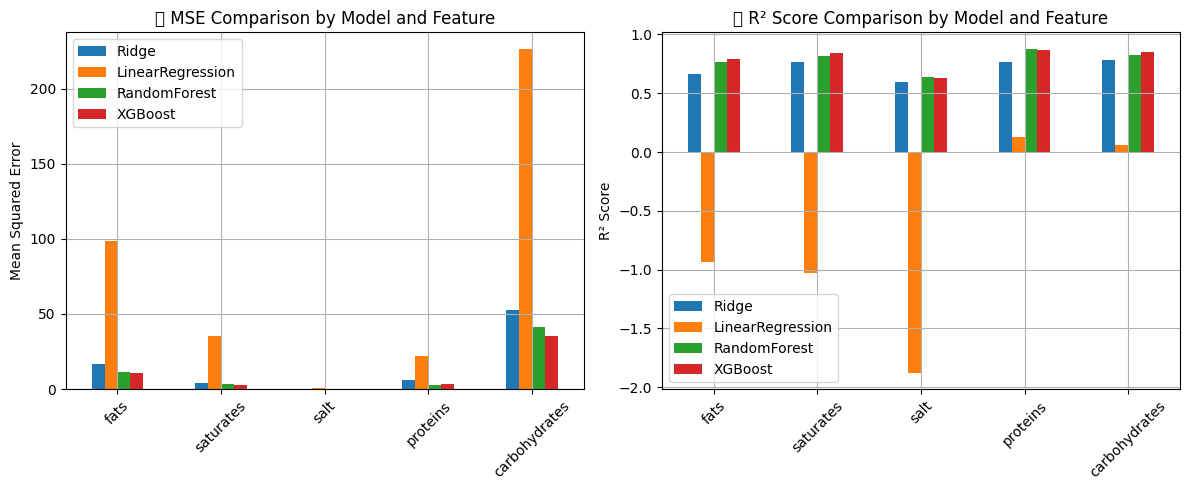

In [8]:
plt.figure(figsize=(12, 5))

# MSE Barplot
plt.subplot(1, 2, 1)
mse_summary.plot(kind='bar', ax=plt.gca())
plt.title("📉 MSE Comparison by Model and Feature")
plt.ylabel("Mean Squared Error")
plt.xticks(rotation=45)
plt.grid(True)

# R² Barplot
plt.subplot(1, 2, 2)
r2_summary.plot(kind='bar', ax=plt.gca())
plt.title("📈 R² Score Comparison by Model and Feature")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()


In [9]:
avg_metrics = pd.DataFrame({
    'Avg MSE': mse_summary.mean(),
    'Avg R²': r2_summary.mean()
})
print("📋 Average Metrics per Model:")
display(avg_metrics.sort_values(by='Avg MSE'))


📋 Average Metrics per Model:


,Avg MSE,Avg R²
XGBoost,10.544103,0.795468
RandomForest,11.907569,0.786627
Ridge,15.974835,0.714649
LinearRegression,76.554233,-0.731854
